# Data Preprocessing

## Import Packages and Set Up Environment

### Import Core Packages

In [2]:
# Import packages
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform
import shutil

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Get Current Operating System and Set Paths Dependent on Working OS

In [19]:
# Get current OS and set paths dependent on working OS.
cur_system = platform.system()

if cur_system == "Linux":   # for linux
    sys.path.extend(['/home/kimqi/Documents/Repositories/NeuroPy'])  # NeuroPy Path

    # Directories for current working session. These need to be set manually.
    session_name = 'Creampuff_20240623_Homecage2'
    basepath = os.getcwd()
    # If notebook is remote
    # basepath = Path('/media/kimqi/BK/Data/PCDisruption/Recording_Rats/Creampuff/2024_06_23_Homecage2')

    save_dir = Path('/home/kimqi/Documents/Code/PlaceCellDisruption/Preprocessing')
    plot_dir = Path('/home/kimqi/Documents/Code/PlaceCellDisruption/Preprocessing/Plots')

elif cur_system == "Windows":   # For Windows
    sys.path.extend(['C:\\BrianKim\\Code\\Repositories\\NeuroPy'])  # NeuroPy Path
    
    # Directories for current working session. These need to be set manually.
    #basepath = Path('/media/kimqi/BK/Data/PCDisruption/Recording_Rats/Creampuff/2024_06_22_HomeCage1')
    #save_dir = Path('/home/kimqi/Documents/Code/PlaceCellDisruption/Analyses/Preliminary')
    #plot_dir = Path('/home/kimqi/Documents/Code/PlaceCellDisruption/Analyses/Plots')

### Import NeuroPy Packages

In [5]:
# Import NeuroPy Packages
from neuropy import core
from neuropy.core import Epoch
from neuropy.core.session import ProcessData


from neuropy.analyses.artifact import detect_artifact_epochs

from neuropy.plotting.signals import plot_signal_w_epochs

from neuropy.io.openephysio import *
from neuropy.io import SpykingCircusIO

### Import Session Data

In [7]:
sess = ProcessData(basepath)
print(sess.recinfo)
print(sess.eegfile)

filename: /media/kimqi/BK/Data/PCDisruption/Recording_Rats/Creampuff/2024_06_23_Homecage2/Creampuff_Homecage2.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250

duration: 1603.54 seconds 
duration: 0.45 hours 



## Preprocess Ephys Data
- Identify Artifacts
    - Disconnects
    - Filtering
- Send events files to check in Neuroscope
- Write `dead_times.txt` file for spyking-circus and `artifacts.npy` files
### Identify Disconnects and Motion Artifacts

Buffer of 0.25 added before/after each epoch
/media/kimqi/BK/Data/PCDisruption/Recording_Rats/Creampuff/2024_06_23_Homecage2/Creampuff_Homecage2.art_epochs.npy saved
Total artifact time = 21.4 seconds
Automatically detected artifact epochs:
      start      stop label  duration
0  586.2084  586.7660          0.5576
1  957.5820  978.4596         20.8776


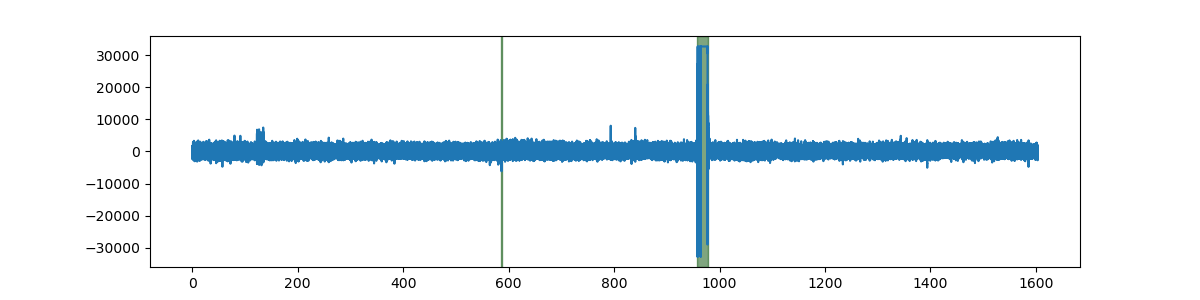

In [27]:
%matplotlib widget

# Parameters
buffer_add = 0.25    # Add buffer before and after detected artifact epochs, None = don't add any
art_thresh = 3       # Artifact detection threshold
art_edge_cutoff = 2  # Edge cutoff value
art_merge = 6        # Merges epochs that are too close to each other

# Get signal object
signal = sess.eegfile.get_signal()

# Find artifact epochs. If file exists already, load that instead of creating a new file.
art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    art_epochs = detect_artifact_epochs(signal, thresh=art_thresh, edge_cutoff=art_edge_cutoff, 
                                        merge=art_merge)
    # Add in a buffer to prevent erroneous detetion of start/stop of artifact as SWRs.
    if buffer_add is not None:
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
print('Automatically detected artifact epochs:')
print(art_epochs.to_dataframe())

# Plot artifact onto an example channel
chan_plot = 15 # Select a good channel
art_fig = plot_signal_w_epochs(signal, chan_plot, art_epochs)
art_fig_name = f'{session_name}_Artifacts_Channel{chan_plot}.png' 
plt.savefig(plot_dir / art_fig_name, dpi=300, bbox_inches='tight')  # Save with full path

### Check Events in Neuroscope
- Load evt.art file in Neuroscope and check if it aligns with artifacts in the signal.
- Check if there are any other artifact epochs that were missed by the automatic detection
### Identify Stimulation Epochs
- Stimulation will have artifacts that are highly stereotyped

In [83]:
# Parameters
SR = sess.recinfo.dat_sampling_rate

# Get sample numbers for TTL Events
ttl_events = load_all_ttl_events(sess.basepath)

stim_on_events = ttl_events.loc[ttl_events["channel_states"] == 1, "sample_number"]
stim_off_events = ttl_events.loc[ttl_events["channel_states"] == -1, "sample_number"]
stim_art_events = ttl_events.loc[ttl_events["channel_states"].abs() == 1, "sample_number"]

# Find Stim epochs. If file exists, already, load that instead of creating a new file.
stim_epochs_file = sess.filePrefix.with_suffix(".stim_epochs.npy")

if stim_epochs_file.exists():
    stim_epochs = Epoch(epochs=None, file=stim_epochs_file)
    print('Existing stim epochs file loaded')
else:
    stim_epochs = Epoch(pd.DataFrame({
        "start": stim_on_events.reset_index(drop=True) / SR, 
        "stop": stim_off_events.reset_index(drop=True) / SR, 
        "label": ""
        }))

    sess.recinfo.write_epochs(epochs=stim_epochs, ext='stm')
    stim_epochs.save(stim_epochs_file)

stim_epochs_df = stim_epochs.to_dataframe()
stim_epochs_df['time_between'] = df_new['start'] - df_new['stop'].shift(1)
pd.set_option('display.max_rows', None)
print('Stim Epochs:')
print(stim_epochs_df)

Existing stim epochs file loaded
Stim Epochs:
           start         stop label  duration  time_between
0     122.573000   122.583000        0.010000           NaN
1     122.626867   122.636867        0.010000      0.043867
2     122.674200   122.684200        0.010000      0.037333
3     122.722067   122.732067        0.010000      0.037867
4     122.769767   122.779767        0.010000      0.037700
5     122.831567   122.841567        0.010000      0.051800
6     122.879100   122.889100        0.010000      0.037533
7     122.925933   122.935933        0.010000      0.036833
8     122.973067   122.983067        0.010000      0.037133
9     122.988700   122.998700        0.010000      0.005633
10    123.020433   123.030433        0.010000      0.021733
11    123.035767   123.045767        0.010000      0.005333
12    123.067933   123.077933        0.010000      0.022167
13    123.130700   123.140700        0.010000      0.052767
14    123.178067   123.188067        0.010000      0.0

#### Session Specific Code

In [57]:
# Grab all stims that are 0.01s (Used for 20Hz Stims)
twentyhz_stim_epochs_file = sess.filePrefix.with_suffix(".twentyhz_stim_epochs.npy")



stim_epochs_df = stim_epochs_df[stim_epochs_df['duration'] <= 0.02]
stim_epochs = Epoch(epochs=twenty_hz_stim, file=twentyhz_stim_epochs_file)

print(twentyhz_stim_df)

          start        stop label  duration
0    122.573000  122.583000        0.010000
1    122.626867  122.636867        0.010000
2    122.674200  122.684200        0.010000
3    122.722067  122.732067        0.010000
4    122.769767  122.779767        0.010000
5    122.831567  122.841567        0.010000
6    122.879100  122.889100        0.010000
7    122.925933  122.935933        0.010000
8    122.973067  122.983067        0.010000
9    122.988700  122.998700        0.010000
10   123.020433  123.030433        0.010000
11   123.035767  123.045767        0.010000
12   123.067933  123.077933        0.010000
13   123.130700  123.140700        0.010000
14   123.178067  123.188067        0.010000
15   123.225200  123.235200        0.010000
16   123.240300  123.250300        0.010000
17   123.272833  123.282833        0.010000
18   123.320867  123.330867        0.010000
19   123.367933  123.377933        0.010000
20   123.431900  123.441900        0.010000
21   123.479100  123.489100     

#### Identify Stimulation Artifacts
Stimulation Artifact can currently be classified in several ways
- TTLs: Timestamps of the stim means we create a buffer around the TTL to determine the artifact.
- Epochs: Epochs of time in which the artifact may exist. We can also add a buffer around the start and end timestamps to encapsulate the artifact better.

In [80]:
# Parameters
# Are the stims set as TTLs (True: buffer around the TTL) or epochs (False: Doesn't necessarily require buffer)
ttl_vs_epoch = False
use_buffer = True
pre_buffer = 0
post_buffer = 0.003

stim_art_epochs_file = sess.filePrefix.with_suffix(".stim_art_epochs.npy")

if ttl_vs_epoch == True:
    
    
    stim_art_epochs = Epoch(pd.DataFrame({
        "start": stim_art_events.reset_index(drop=True) / SR - pre_buffer, 
        "stop": stim_art_events.reset_index(drop=True) / SR + post_buffer, 
        "label": ""
    }))
    
    sess.recinfo.write_epochs(epochs=stim_art_epochs, ext='sta')
    stim_art_epochs.save(stim_art_epochs_file)

elif ttl_vs_epoch == False:
    
    if use_buffer == True:
        stim_art_epochs = Epoch(pd.DataFrame({
            "start": stim_epochs_df['start'].reset_index(drop=True) - pre_buffer, 
            "stop": stim_epochs_df['stop'] + post_buffer, 
            "label": ""
        }))

    sess.recinfo.write_epochs(epochs=stim_art_epochs, ext='sta')
    stim_art_epochs.save(stim_art_epochs_file)

stim_art_epochs_df = stim_art_epochs.to_dataframe()
stim_art_epochs_df['time_between'] = stim_art_epochs_df['start'] - stim_art_epochs_df['stop'].shift(1)

print(stim_art_epochs_df)

/media/kimqi/BK/Data/PCDisruption/Recording_Rats/Creampuff/2024_06_23_Homecage2/Creampuff_Homecage2.stim_art_epochs.npy saved
           start         stop label  duration  time_between
0     122.573000   122.586000        0.013000           NaN
1     122.626867   122.639867        0.013000      0.040867
2     122.674200   122.687200        0.013000      0.034333
3     122.722067   122.735067        0.013000      0.034867
4     122.769767   122.782767        0.013000      0.034700
5     122.831567   122.844567        0.013000      0.048800
6     122.879100   122.892100        0.013000      0.034533
7     122.925933   122.938933        0.013000      0.033833
8     122.973067   122.986067        0.013000      0.034133
9     122.988700   123.001700        0.013000      0.002633
10    123.020433   123.033433        0.013000      0.018733
11    123.035767   123.048767        0.013000      0.002333
12    123.067933   123.080933        0.013000      0.019167
13    123.130700   123.143700     

#### Write Stim Artifact to a Trigger Detection File

In [82]:
# Function to generate stim_times
def format_row(row):
    prefix = '0' if row['duration'] < 0.05 else '1'
    start_ms = row['start'] * 1000
    return f"{prefix} {start_ms:.6f}"

# Apply the function to each row and save to a text file
output = stim_art_epochs.to_dataframe().apply(format_row, axis=1)

# Save to text file
file_path = '/media/kimqi/BK/Data/PCDisruption/Recording_Rats/Creampuff/2024_06_23_Homecage2/spyk-circ/stim_times.txt'
output.to_csv(file_path, index=False, header=False)

file_path

'/media/kimqi/BK/Data/PCDisruption/Recording_Rats/Creampuff/2024_06_23_Homecage2/spyk-circ/stim_times.txt'

### Write to Spyking-Circus `dead_times.txt` File
- Text file containing 2 columns, start and stop of artifact epochs that should be ignored by spike sorting algorithm.

In [59]:
sess.filePrefix.with_suffix(".art_epochs.npy")
SpykingCircusIO.write_epochs(sess.basepath / 'dead_times.txt', art_epochs)

dead_times.txt created
